In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

import tqdm
from tqdm import trange
from tqdm import tqdm

In [2]:
# Try to predict a sine wave
class SineWaveDataset(Dataset):
    def __init__(self, w, phi, num_points=1000):
        self.num_points = num_points
        self.w = w
        self.phi = phi
        self.x = np.linspace(0, 2*np.pi, num_points)
        self.y = np.sin(self.x*self.w + self.phi)

    def __len__(self):
        return self.num_points

    def __getitem__(self, idx):

        # Convert to tensor
        return torch.tensor([self.x[idx],self.w, self.phi]).float(), torch.tensor([self.y[idx]]).float()

In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from scipy.stats import qmc

# Define the number of samples
n_samples = 9  # Number of samples

# Create a Latin Hypercube sampler
sampler = qmc.LatinHypercube(d=2)

# Generate samples
samples = sampler.random(n_samples)

# Scale the samples to the desired ranges
samples_scaled = qmc.scale(samples, [0, 0.1], [50, np.pi])  # Scale to range [0.5, 50]
frequencies = samples_scaled[:, 0]
phases = samples_scaled[:, 1]

print("Frequencies: ", np.mean(frequencies), np.std(frequencies))
print("Phases: ", np.mean(phases), np.std(phases))

# Create a dataset for each combination of frequency and phase
datasets = [SineWaveDataset(w, phi) for w, phi in zip(frequencies, phases)]

# Join all datasets
dataset = torch.utils.data.ConcatDataset(datasets)

# Separate the data into training, validation and test sets
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print("Train size: ", len(train_dataset))
print("Validation size: ", len(val_dataset))
print("Test size: ", len(test_dataset))

# Create a dataloader
i_batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=i_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=i_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=i_batch_size, shuffle=True)
print("Train batches: ", len(train_loader))
print("Validation batches: ", len(val_loader))
print("Test batches: ", len(test_loader))

Frequencies:  24.716000698146104 14.612986653018766
Phases:  1.5974258517664872 0.8109103950279906
Train size:  7200
Validation size:  900
Test size:  900
Train batches:  720
Validation batches:  90
Test batches:  90


In [4]:
# Create a simple neural network
class SineWavePredictor(nn.Module):
    def __init__(self):
        super(SineWavePredictor, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [5]:
class BayesianRegularizedNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BayesianRegularizedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Create the model
model = BayesianRegularizedNN(3, 128, 1)

# Initialize the weights with a He initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)

model.apply(init_weights)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)


In [7]:
# Loss with L1 regularization
def l1_regularization(model, lambda_l1=0.01):
    l1 = 0
    for p in model.parameters():
        l1 = l1 + p.abs().sum()
    return lambda_l1 * l1

def total_loss(model, criterion, output, target, lambda_l1=0.01):
    return criterion(output, target) + l1_regularization(model, lambda_l1)

# Early stopping class
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')




In [8]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [9]:
# Train the model
num_epochs = 1000
losses = []
val_losses = []
model.to(device)
progress_bar = tqdm(range(num_epochs), desc="Training", unit="epoch")
early_stopping = EarlyStopping(patience=50, progress_bar=progress_bar)

for epoch in progress_bar:
    avg_loss = 0
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss =criterion(outputs, targets)
        #loss = total_loss(model, criterion, outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    losses.append(avg_loss)

    # Early stopping
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            #loss = total_loss(model, criterion, outputs, targets)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        early_stopping(val_loss, model)

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss}, Validation loss: {val_loss}')

    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Stop if losses are nan values
    if np.isnan(avg_loss) or np.isnan(val_loss):
        print("Loss is NaN")
        break

Training:   0%|          | 1/1000 [00:05<1:30:34,  5.44s/epoch]

Epoch 0, Loss: 0.9065556938449542, Validation loss: 1.527395984530449


Training:   5%|▌         | 51/1000 [01:33<25:41,  1.62s/epoch, EarlyStopping counter: 4 out of 50] 

Epoch 50, Loss: 0.5414855336977376, Validation loss: 0.4819601860311296


Training:   7%|▋         | 72/1000 [02:10<28:07,  1.82s/epoch]                                     


KeyboardInterrupt: 

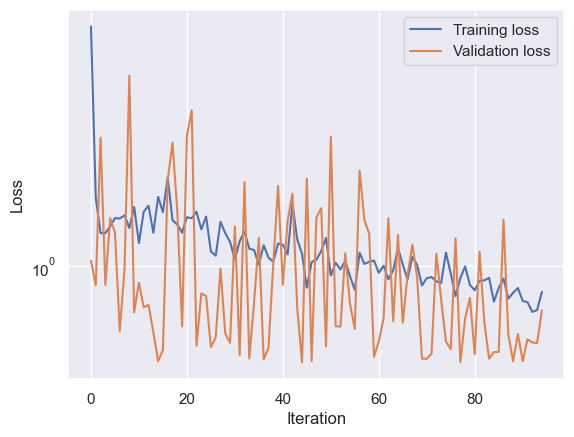

In [ ]:
# Plot the loss
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [275]:
# Test the model
model.eval()
test_losses = []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_losses.append(loss.item())
    print(f"Test Loss: {np.mean(test_losses)}")


Test Loss: 0.7087428538335694


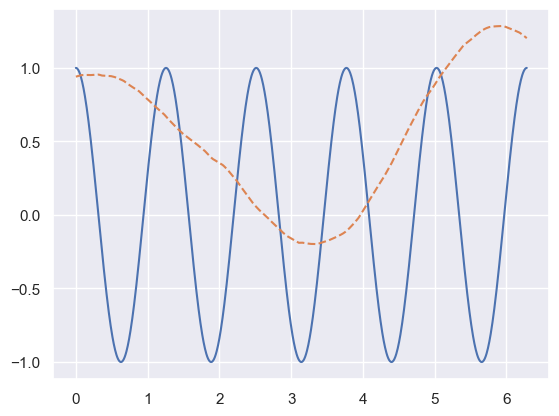

In [276]:
# Let's see how the model performs
w = 5
phi = np.pi/2

# Create a dataset
test_dataset = SineWaveDataset(w, phi, num_points=1000)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Predict the values
predictions = []
with torch.no_grad():
    for i, (inputs, _) in enumerate(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())

# Plot the predictions
plt.plot(test_dataset.x, test_dataset.y, label='True values')
plt.plot(test_dataset.x, predictions, label='Predictions', linestyle='dashed')